# Data distribution example

Produce figure to illustrate distribution of measurements of ionospheric electrodynamics on 5 April 2012. The figure will show *SuperMAG* horizontal ground magnetic field perturbations, *Iridium* horizontal magnetic field perturbations in space (provided by [AMPERE](http://ampere.jhuapl.edu/)), and the location of *SuperDARN* line-of-sight plasma convection measurements.

Start by importing relevant modules:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import lompe 
import cartopy.io.shapereader as shpreader # for showing coastlines

Get the input data from files. For this example, the files are pre-made and saved in *'./sample_dataset'*. See *Data_handling_with_Lompe* for explanation on how to get the data on this format.

In [2]:
# paths to files
supermagfn = '../sample_dataset/20120405_supermag.h5'
superdarnfn = '../sample_dataset/20120405_superdarn_grdmap.h5' 
iridiumfn = '../sample_dataset/20120405_iridium.h5'

# load data
supermag  = pd.read_hdf(supermagfn)
superdarn = pd.read_hdf(superdarnfn) 
iridium   = pd.read_hdf(iridiumfn)

The sample data files cover a whole day (2014-04-05). Select a subset from a given time interval and latitude range (above 50$^\circ$ latitude)

In [3]:
DT = dt.timedelta(seconds=4*60) # duration of model interval
date = dt.datetime(2012, 4, 5, 1, 0) # center time
t0 = date - DT/2 # start
t1 = date + DT/2 # end

print('Model interval is ' + str(t0) + ' UT to ' + str(t1) + ' UT')

# Iridium data:
irid = iridium[(iridium.time >= t0) & (iridium.time <= t1) & (iridium.lat > 50)]

# SuperMAG data:
smag = supermag.loc[t0:t1, :]
smag = smag[smag.lat > 50] 

print('SuperMAG data from: ' + str(smag.index.min()) + ' UT to ' + str(smag.index.max()) + ' UT')
print('Iridium data from: ' + str(irid.time.min()) + ' UT to ' + str(irid.time.max()) + ' UT')

# SuperDARN data:
sd = superdarn.loc[t0:t1, :]
sd = sd[sd.glat > 50]

Model interval is 2012-04-05 00:58:00 UT to 2012-04-05 01:02:00 UT
SuperMAG data from: 2012-04-05 00:58:00 UT to 2012-04-05 01:02:00 UT
Iridium data from: 2012-04-05 00:58:01 UT to 2012-04-05 01:01:59 UT


Set up the figure using *lompe.model.visualization.Polarsubplot()*, and add the data on the plot

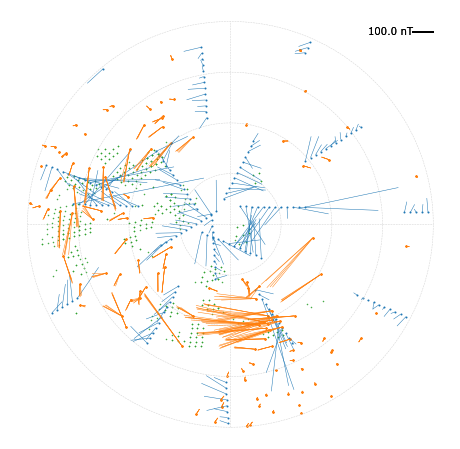

In [4]:
fig, ax = plt.subplots(figsize = (8, 8))
pax = lompe.model.visualization.Polarsubplot(ax)

# plot Iridium in blue
pax.plotpins(irid.lat.values, irid.lon.values / 15, irid.B_e.values, irid.B_n.values, 
             SCALE = 100, markersize = 1, markercolor = 'C0', linewidths = .5, colors = 'C0', unit = 'nT')

# plot SuperMAG in orange
pax.plotpins(smag.lat.values, smag.lon.values / 15, smag.Be.values, smag.Bn.values, 
             SCALE = 100, markersize = 1, markercolor = 'C1', linewidths = .5, colors = 'C1', unit = 'nT')

# plot SuperDARN (gridded) backscatter locations in green
pax.scatter(sd.glat.values, sd.glon.values / 15, c = 'C2', s = 1, marker = '.');

Add frames of the cubed sphere grids used in example figures

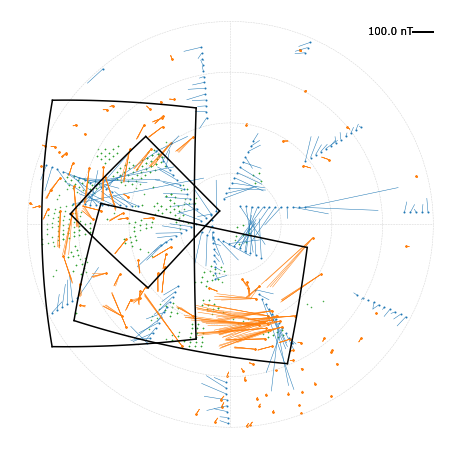

In [5]:
positions = [(-90, 68), (-98,73), (-31.5, 75.7) ]            # lon, lat for grid centers
orientations = [0, -36, 20]                                  # angle, wrt circle of latitude, of grid x axis
Ls, Ws = [7000e3, 2500e3, 6000.e3], [3800e3, 2500e3, 3000e3] # extents [m] of grids
dLs, dWs = [100e3, 70e3, 75e3], [100e3, 70e3, 75e3]          # spatial resolution [m] of grid 

# create grid objects:
grids = []
for position, orientation, L, W, dL, dW in zip(positions, orientations, Ls, Ws, dLs, dWs):
    projection = lompe.cs.CSprojection(position, orientation)
    grids.append(lompe.cs.CSgrid(projection, L, W, dL, dW, R = 6481.2e3) )
    
# plot grid frames on the map:
for grid in grids:
    pax.plot(grid.lat_mesh[ :,  0], grid.lon_mesh[ :,  0] / 15, color = 'black')
    pax.plot(grid.lat_mesh[ :, -1], grid.lon_mesh[ :, -1] / 15, color = 'black')
    pax.plot(grid.lat_mesh[-1,  :], grid.lon_mesh[-1,  :] / 15, color = 'black')
    pax.plot(grid.lat_mesh[ 0,  :], grid.lon_mesh[ 0,  :] / 15, color = 'black')

fig

Add coastlines

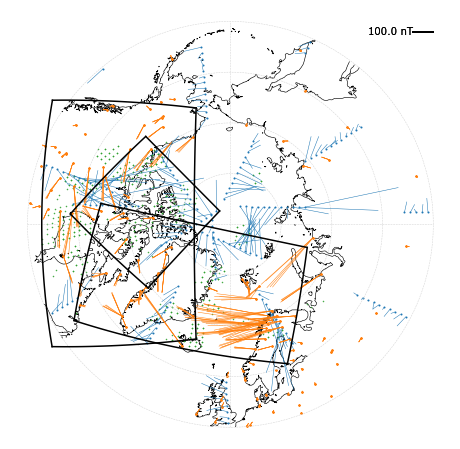

In [6]:
clkw = {'resolution':'50m', 'category':'physical', 'name':'coastline'} # shpreader parameters

shpfilename = shpreader.natural_earth(**clkw)
reader = shpreader.Reader(shpfilename)
coastlines = reader.records()
multilinestrings = []
for coastline in coastlines:
    if coastline.geometry.geom_type == 'MultiLineString':
        multilinestrings.append(coastline.geometry)
        continue

    lon, lat = np.array(coastline.geometry.coords[:]).T 
    lon[lat < 50] = np.nan
    lat[lat < 50] = np.nan # mask points outside grid
    
    pax.plot(lat, lon/15, color = 'black', zorder = -1, linewidth = .6)

    
for mls in multilinestrings:
    for ls in mls:
        lon, lat = np.array(ls.coords[:]).T 
        lon[lat < 50] = np.nan
        lat[lat < 50] = np.nan # mask points outside grid        

        pax.plot(lat, lon/15, color = 'black', zorder = -1, linewidth = .6)

fig

The blue lines represent horizontal magnetic field disturbances measured from the fleet of *Iridium* satellites, provided by AMPERE. The orange lines represent horizontal magnetic field disturbances on ground, from *SuperMAG*. A scale for the *Iridium* and *SuperMAG* magnetic field vectors is shown in the top right corner. The green dots
represent the locations of *SuperDARN* backscatter, which provides estimates of the line-of-sight plasma convection velocity. The frames show the extent of the grids used in example figures (notebooks 04, 05 and 06).

In [7]:
fig.savefig('output_figures/data_distribution_example.pdf')
fig.savefig('output_figures/data_distribution_example.png', dpi = 250)